# Make a smaller data set for testing models

In [1]:
library(nakedpipe)
library(tidyverse)

theme_set(theme_minimal(base_size=11))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.1
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [21]:
data_dir <- here::here("modeling_data")
modeling_data_path <- file.path(data_dir, "depmap_modeling_dataframe.csv")
out_path <- file.path(data_dir, "depmap_modeling_dataframe_subsample.csv")
cellline_subsample_out_path <- file.path(data_dir, "depmap_modeling_dataframe_subsample-medium.csv")

In [4]:
modeling_data <- read_csv(modeling_data_path, guess_max = 1e5)
head(modeling_data)

Parsed with column specification:
cols(
  .default = col_character(),
  lfc = col_double(),
  pdna_batch = col_double(),
  passes_qc = col_logical(),
  n_alignments = col_double(),
  chrom_pos = col_double(),
  segment_mean = col_double(),
  segment_cn = col_double(),
  log2_gene_cn_p1 = col_double(),
  gene_cn = col_double(),
  n_muts = col_double(),
  any_deleterious = col_logical(),
  mutated_at_guide_location = col_logical(),
  rna_expr = col_double()
)

See spec(...) for full column specifications.



sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,⋯,log2_gene_cn_p1,gene_cn,n_muts,any_deleterious,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr
<chr>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>
AAAAAAATCCAGCAATGCAG,143b-311cas9_repa_p6_batch3,0.2896938,3,TRUE,ACH-001001,Primary,bone,osteosarcoma,G12S,⋯,1.0999200,2.003926,0,FALSE,NA,NA,NA,NA,FALSE,4.1009776
AAAAAACCCGTAGATAGCCT,143b-311cas9_repa_p6_batch3,0.1701723,3,TRUE,ACH-001001,Primary,bone,osteosarcoma,G12S,⋯,0.9146094,1.495800,0,FALSE,NA,NA,NA,NA,FALSE,7.4709435
AAAAAAGAAGAAAAAACCAG,143b-311cas9_repa_p6_batch3,-0.6959467,3,TRUE,ACH-001001,Primary,bone,osteosarcoma,G12S,⋯,0.9219114,1.514091,0,FALSE,NA,NA,NA,NA,FALSE,4.6270231
AAAAAAGCTCAAGAAGGAGG,143b-311cas9_repa_p6_batch3,-0.3249354,3,TRUE,ACH-001001,Primary,bone,osteosarcoma,G12S,⋯,1.0329204,1.809258,0,FALSE,NA,NA,NA,NA,FALSE,4.7750505
AAAAAAGGCTGTAAAAGCGT,143b-311cas9_repa_p6_batch3,0.1428739,3,TRUE,ACH-001001,Primary,bone,osteosarcoma,G12S,⋯,0.9064726,1.475575,0,FALSE,NA,NA,NA,NA,FALSE,0.2265085
AAAAAAGGGCTCCAAAAAGG,143b-311cas9_repa_p6_batch3,-0.2998787,3,TRUE,ACH-001001,Primary,bone,osteosarcoma,G12S,⋯,1.0604597,1.887698,0,FALSE,NA,NA,NA,NA,FALSE,0.3785116


In [5]:
glimpse(modeling_data)

Rows: 120,235,860
Columns: 27
$ sgrna                     <chr> "AAAAAAATCCAGCAATGCAG", "AAAAAACCCGTAGATAGC…
$ replicate_id              <chr> "143b-311cas9_repa_p6_batch3", "143b-311cas…
$ lfc                       <dbl> 0.28969381, 0.17017231, -0.69594665, -0.324…
$ pdna_batch                <dbl> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3…
$ passes_qc                 <lgl> TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, T…
$ depmap_id                 <chr> "ACH-001001", "ACH-001001", "ACH-001001", "…
$ primary_or_metastasis     <chr> "Primary", "Primary", "Primary", "Primary",…
$ lineage                   <chr> "bone", "bone", "bone", "bone", "bone", "bo…
$ lineage_subtype           <chr> "osteosarcoma", "osteosarcoma", "osteosarco…
$ kras_mutation             <chr> "G12S", "G12S", "G12S", "G12S", "G12S", "G1…
$ genome_alignment          <chr> "chr10_110964620_+", "chr12_95003615_+", "c…
$ n_alignments              <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ hugo_symbol         

In [6]:
# Number of unique guides.
n_distinct(modeling_data$sgrna)

[1] 72133

In [7]:
# Number of unique cell lines.
n_distinct(modeling_data$depmap_id)

[1] 767

In [8]:
# Number of genes.
n_distinct(modeling_data$hugo_symbol)

[1] 18524

In [9]:
# Some specific genes to subset.
specific_genes <- c("KRAS", "BRAF", "PIK3CA", "PTK2", "MDM2", "TP53")
ceres_correction_genes <- c("TRPS1", "ESR1", "NAMPT", "CDK4")

set.seed(0)
num_random_genes <- 20
subsample_genes <- c(
    sample(unique(modeling_data$hugo_symbol), num_random_genes),
    specific_genes
)

# Check that all genes are actually in the modeling data.
all(subsample_genes %in% modeling_data$hugo_symbol)

[1] TRUE

In [10]:
subsample_genes

[1] "PHACTR3"   "ZSWIM8"    "DPH7"      "LGALS7B"   "DISP1"     "KIF3C"    
 [7] "RNF125"    "LGALS4"    "SLC7A14"   "UQCRC1"    "SCMH1"     "SMAD7"    
[13] "GHSR"      "IQCK"      "NDUFAF3"   "FAM43B"    "PDE5A"     "HIST1H2BO"
[19] "ADAMTS13"  "CXCL2"     "KRAS"      "BRAF"      "PIK3CA"    "PTK2"     
[25] "MDM2"      "TP53"

In [11]:
sort(unique(modeling_data$lineage))

[1] "bile_duct"                 "blood"                    
 [3] "bone"                      "breast"                   
 [5] "central_nervous_system"    "cervix"                   
 [7] "colorectal"                "esophagus"                
 [9] "eye"                       "fibroblast"               
[11] "gastric"                   "kidney"                   
[13] "liver"                     "lung"                     
[15] "lymphocyte"                "ovary"                    
[17] "pancreas"                  "peripheral_nervous_system"
[19] "plasma_cell"               "prostate"                 
[21] "skin"                      "soft_tissue"              
[23] "thyroid"                   "upper_aerodigestive"      
[25] "urinary_tract"             "uterus"

In [12]:
lineages <- c("colorectal", "pancreas", "lung", "liver", "central_nervous_system")
modeling_data %>%
    filter(lineage %in% lineages) %>%
    distinct(lineage, depmap_id) %>%
    count(lineage)

lineage,n
<chr>,<int>
central_nervous_system,60
colorectal,36
liver,22
lung,106
pancreas,34


In [13]:
subsample_modeling_data <- modeling_data %>% 
    filter(hugo_symbol %in% !!subsample_genes) %>%
    filter(lineage %in% !!lineages)

pryr::object_size(subsample_modeling_data)

Registered S3 method overwritten by 'pryr':
  method      from
  print.bytes Rcpp



12.4 MB

In [14]:
nrow(subsample_modeling_data)

[1] 60049

In [15]:
subsample_modeling_data %>%
    filter(is.na(lfc)) %>%
    nrow()

[1] 0

In [16]:
subsample_modeling_data %>%
    filter(is.na(segment_cn)) %>%
    nrow()

[1] 206

In [17]:
subsample_modeling_data %>%
    filter(is.na(gene_cn)) %>%
    nrow()

[1] 0

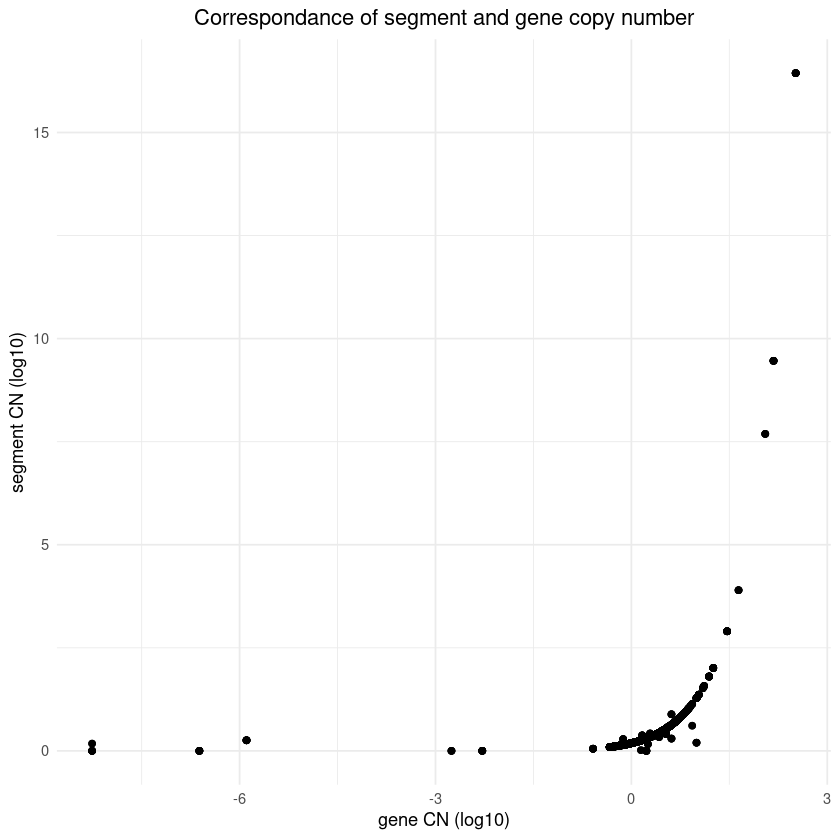

In [18]:
subsample_modeling_data %>%
    filter(!is.na(segment_cn) & !is.na(gene_cn)) %>%
    ggplot(aes(x = log10(gene_cn), y = log10(segment_cn))) +
    geom_point() +
    theme(plot.title = element_text(hjust = 0.5)) +
    labs(x = "gene CN (log10)", 
         y = "segment CN (log10)", 
         title = "Correspondance of segment and gene copy number")

Warning message:
“Removed 2 rows containing missing values (geom_bar).”


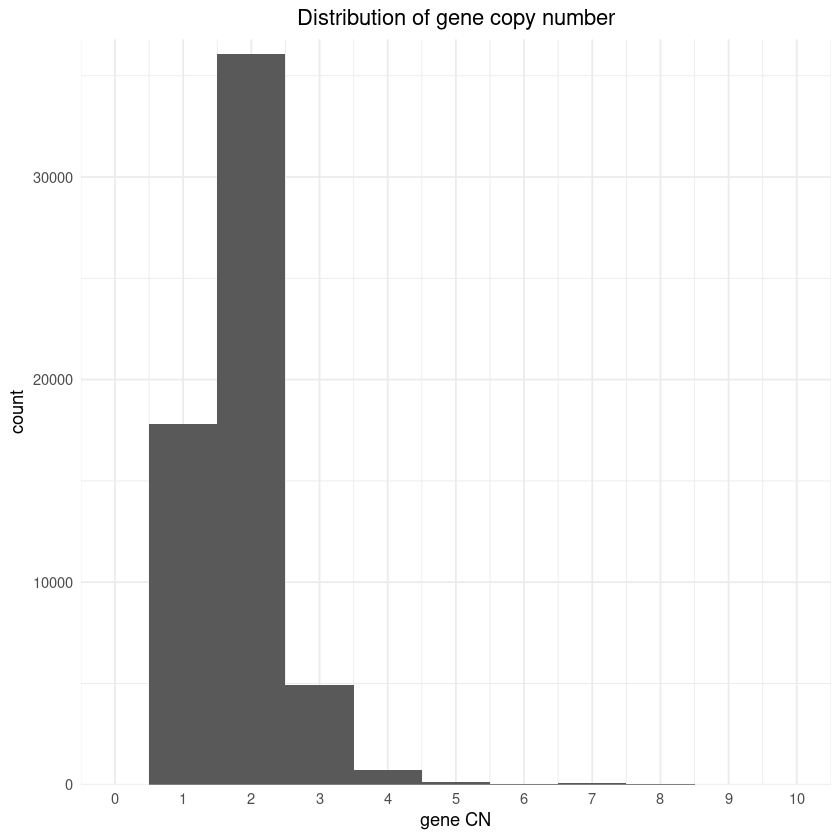

In [19]:
subsample_modeling_data %>%
    mutate(gene_cn = scales::squish(gene_cn, range = c(0, 10))) %>%
    ggplot(aes(x = gene_cn)) +
    geom_histogram(binwidth = 1) +
    scale_x_continuous(limits = c(0, 10), breaks = c(0:12)) +
    scale_y_continuous(expand = expansion(mult = c(0, 0.02))) +
    theme(plot.title = element_text(hjust = 0.5)) +
    labs(x = "gene CN", 
         y = "count",
         title = "Distribution of gene copy number")

In [20]:
write_csv(subsample_modeling_data, out_path)

## All genes from a few cell lines

In [22]:
set.seed(0)
num_random_cell_lines <- 5
cell_lines <- c(
    "ACH-000146",  # THP-1
    sample(unique(modeling_data$depmap_id), 
           num_random_cell_lines, 
           replace = FALSE)
)

cellline_subsample_modeling_data <- modeling_data %>%
    filter(depmap_id %in% !!cell_lines) %>%
    filter(!is.na(gene_cn))

n_genes <- 500
subsample_genes <- sample(unique(cellline_subsample_modeling_data$hugo_symbol), 
                          n_genes, 
                          replace = FALSE)

cellline_subsample_modeling_data <- cellline_subsample_modeling_data %>%
    filter(hugo_symbol %in% !!subsample_genes)

# Number of data points.
nrow(cellline_subsample_modeling_data)

[1] 25922

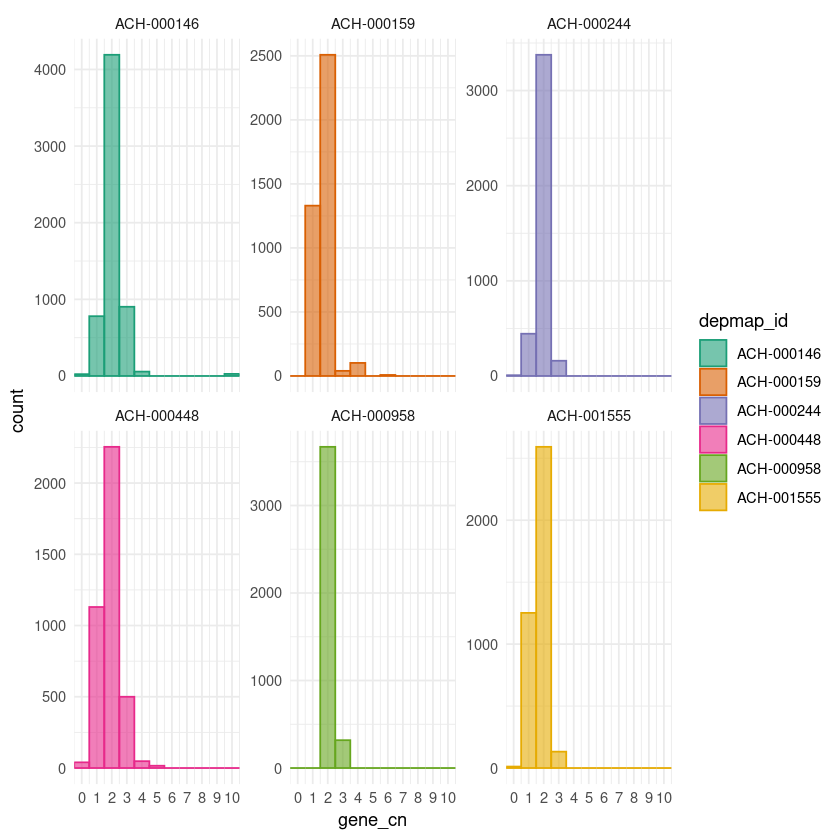

In [23]:
cellline_subsample_modeling_data %>%
    mutate(gene_cn = ifelse(gene_cn < 10, gene_cn, 10)) %>%
    ggplot(aes(x = gene_cn)) +
    facet_wrap(~ depmap_id, nrow = 2, scales = "free_y") +
    geom_histogram(aes(color = depmap_id, fill = depmap_id), binwidth = 1, alpha = 0.6) +
    scale_x_continuous(expand = expansion(mult = c(0, 0)), breaks = 0:12)+
    scale_color_brewer(type = "qual", palette = "Dark2") +
    scale_fill_brewer(type = "qual", palette = "Dark2")

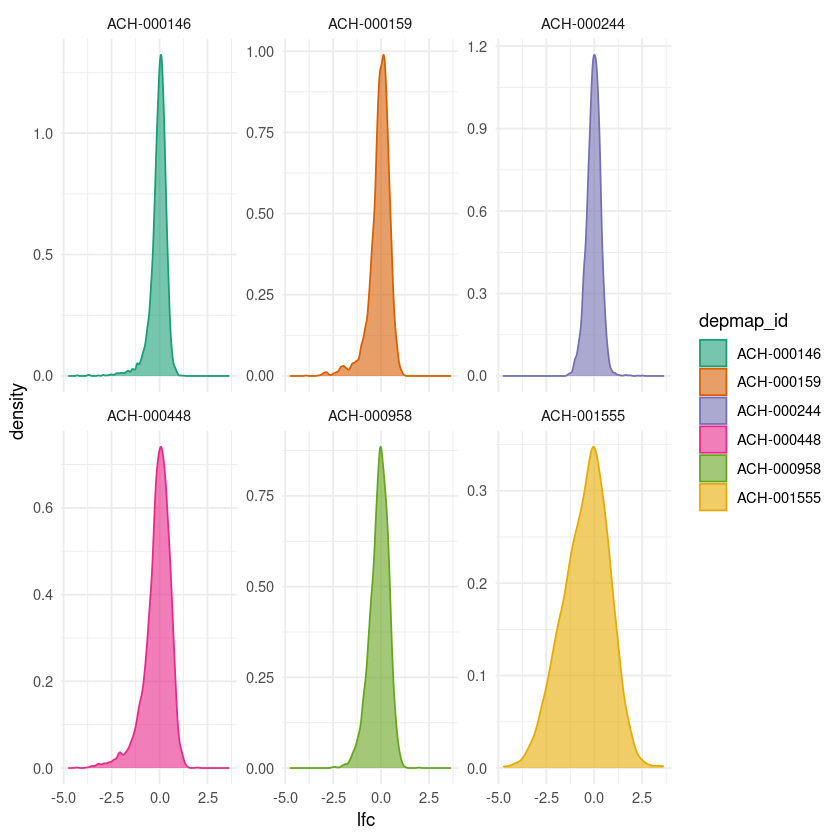

In [24]:
cellline_subsample_modeling_data %>%
    ggplot(aes(x = lfc)) +
    facet_wrap(~ depmap_id, nrow = 2, scales = "free_y") +
    geom_density(aes(color = depmap_id, fill = depmap_id), alpha = 0.6) +
    scale_color_brewer(type = "qual", palette = "Dark2") +
    scale_fill_brewer(type = "qual", palette = "Dark2")

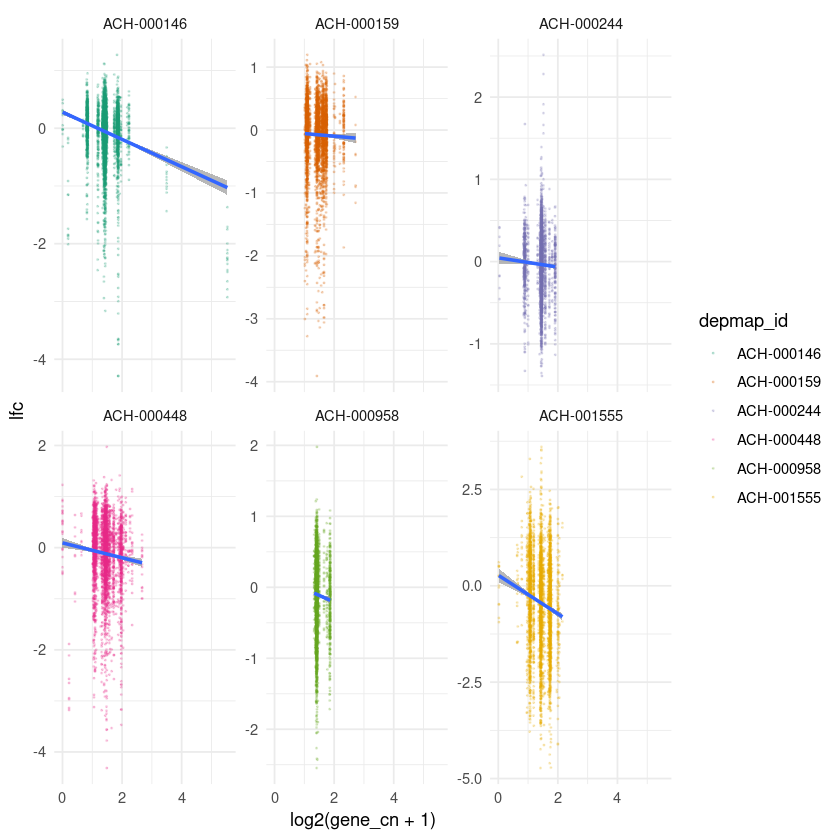

In [25]:
cellline_subsample_modeling_data %>%
    ggplot(aes(x = log2(gene_cn + 1), y = lfc)) +
    facet_wrap(~ depmap_id, nrow = 2, scales = "free_y") +
    geom_point(aes(color = depmap_id), size = 0.2, alpha = 0.2) +
    geom_smooth(method = "lm", formula = "y ~ x", alpha = 0.7) +
    scale_color_brewer(type = "qual", palette = "Dark2")

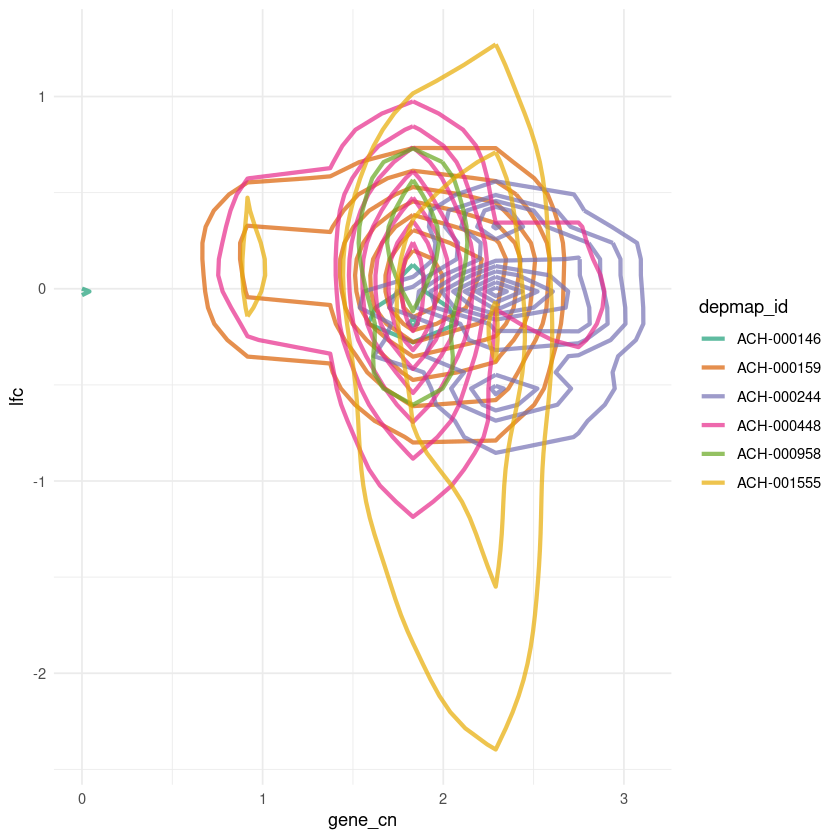

In [26]:
cellline_subsample_modeling_data %>%
    ggplot(aes(x = gene_cn, y = lfc)) +
    geom_density_2d(aes(color = depmap_id), size = 1.2, alpha = 0.7) +
    scale_color_brewer(type = "qual", palette = "Dark2")

In [27]:
write_csv(cellline_subsample_modeling_data, cellline_subsample_out_path)